In [1]:
from typing import List
from logging import warning
import numpy as np
import cv2 as cv
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from skimage import io


In [2]:
IS_NOTEBOOK: bool = True  # @param {type: "boolean"}
NORMAL_MAP_FILE_NAME: str = "normal.png"  # @param {type: "string"}

PATH_PREFIX: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/photometric-stereo-mappings/main/test_dataset/"
    if IS_NOTEBOOK
    else "./../test_dataset/"
)

LIGHT_IMAGE_PATHS: List[str] = [
    PATH_PREFIX + str(index) + ".png" for index in range(1, 8 + 1)
]
MASK_PATH = PATH_PREFIX + "output/opacity.png"
OUTPUT_PATH = None if IS_NOTEBOOK else PATH_PREFIX + "output/" + NORMAL_MAP_FILE_NAME


In [3]:
def _read_image(
    image_path: str, color: bool = True, target_dtype: np.dtype = np.dtype("float64")
) -> np.ndarray:
    """Reads an image from URI and converts it to an array with specified bit depth.

    Args:
        image_path (str): The path to the image file.
        color (bool, optional): Read image as color image. Defaults to True.
        target_dtype (np.dtype, optional): The target bit depth. Defaults to np.dtype("float64").

    Returns:
        np.ndarray: The output array with shape (w,h,3) for color or (w,h) for grayscale images.
    """
    image = io.imread(image_path)
    image_dtype: np.dtype = image.dtype
    image = image.astype(target_dtype)

    if image_dtype == np.dtype("uint8"):
        image /= pow(2, 8) - 1
    elif image_dtype == np.dtype("uint16"):
        image /= pow(2, 16) - 1
    elif image_dtype == np.dtype("uint32"):
        image /= pow(2, 32) - 1

    if color:
        if len(image.shape) == 3:
            return image
        elif len(image.shape) == 2:
            return np.array([image, image, image])
        elif len(image.shape) == 4:
            return np.array([image[:, :, 0], image[:, :, 1], image[:, :, 2]])
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )
    else:
        if len(image.shape) == 2:
            return image
        elif len(image.shape) == 3 or len(image.shape) == 4:
            return (image[:, :, 0] + image[:, :, 1] + image[:, :, 2]) / 3
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )

    return image

In [4]:
def _rpca_inexact_alm(D, lambda_=None, max_ite=1000, tol=1.0e-6):
    if D.ndim != 2:
        raise ValueError("Input matrix D needs to be a matrix.")

    (m, n) = D.shape
    if lambda_ is None:
        lambda_ = 1.0 / np.sqrt(max(m, n))

    Y = D
    norm_two = np.linalg.svd(Y, full_matrices=False, compute_uv=False)[0]
    norm_inf = np.max(np.abs(Y[:])) / lambda_
    dual_norm = max(norm_two, norm_inf)
    Y = Y / dual_norm

    A = np.zeros((m, n))
    E = np.zeros((m, n))
    mu = 1.25 / norm_two  # This can be tuned
    MU_MAXIMUM = mu * 1e7
    RHO = 1.5  # This can be tuned
    D_NORM = np.linalg.norm(D, "fro")
    ite = 0
    sv = 10  # This can be tuned

    while ite < max_ite:
        ite += 1
        T = D - A + (1 / mu) * Y
        E = np.maximum(T - lambda_ / mu, 0.0)
        E = E + np.minimum(T + lambda_ / mu, 0.0)
        U, S, V = np.linalg.svd(D - E + (1.0 / mu) * Y, full_matrices=False)
        svp = len(S[S > 1.0 / mu])
        if svp < sv:
            sv = min(svp + 1, n)
        else:
            sv = min(svp + round(0.05 * n), n)
        A = U[:, 0:svp].dot(np.diag(S[0:svp] - 1.0 / mu)).dot((V[0:svp, :]))
        Z = D - A - E
        Y = Y + mu * Z
        mu = min(mu * RHO, MU_MAXIMUM)
        stop_criterion = np.linalg.norm(Z, "fro") / D_NORM
        if stop_criterion < tol:
            return A, E, ite

    warning("Exceeded the maximum number of iterations.")
    return A, E, ite


In [5]:
def normal_map(
    light_images_paths: List[str],
    output_path: str = None,
    mask_path: str = None,
    open_gl: bool = True,
    pseudo_compress: bool = True,
    robust_lagrangian: bool = False,
    light_positions: np.ndarray = np.array(
        [
            [-0.389346, 0.0836132, 0.917289],
            [-0.347731, -0.173368, 0.921427],
            [-0.130761, -0.350568, 0.927364],
            [0.146212, -0.331608, 0.932018],
            [0.344156, -0.137129, 0.928845],
            [0.319508, 0.200581, 0.926111],
            [0.0570113, 0.391984, 0.918204],
            [-0.240954, 0.327253, 0.913699],
        ]
    ),
):
    """Computes and saves the normal mapping. Photometric stereo normal mapping.
    Woodham, Robert J. "Photometric method for determining surface orientation from multiple images."
    Optical engineering 19.1 (1980): 139-144.
    Args:
        light_images_paths (List[str]): Paths to the light images.
        output_path (str, optional): Path where the output image file should be saved.
        mask (str, optional): Path of the mask that gets applied on the normal map.
        open_gl (bool, optional): Inverts the y-/green-channel before normalization. Defaults to True.
        pseudo_compress (bool, optional): Normal map compressing with (n+1)/2. Defaults to True.
        robust_lagrangian (bool, optional): More robust against reflections and other errors that arise mainly when using non-polarized light sources.
                                            Wu, Lun, et al. "Robust photometric stereo via low-rank matrix completion and recovery."
                                            Asian Conference on Computer Vision. Springer, Berlin, Heidelberg, 2010.
                                            Defaults to False.
        light_positions (np.ndarray, optional): The light position matrix in Cartesian coordinates.
                                                Defaults to np.array( [ [-0.389346, 0.0836132, 0.917289],
                                                                        [-0.347731, -0.173368, 0.921427],
                                                                        [-0.130761, -0.350568, 0.927364],
                                                                        [0.146212, -0.331608, 0.932018],
                                                                        [0.344156, -0.137129, 0.928845],
                                                                        [0.319508, 0.200581, 0.926111],
                                                                        [0.0570113, 0.391984, 0.918204],
                                                                        [-0.240954, 0.327253, 0.913699], ] ).
    """
    L = light_positions.T
    M = None
    height = 0
    width = 0

    # loading light images
    for fname in light_images_paths:
        im = _read_image(fname, color=False)
        if M is None:
            height, width = im.shape
            M = im.reshape((-1, 1))
        else:
            M = np.append(M, im.reshape((-1, 1)), axis=1)

    A = M.T
    if robust_lagrangian:
        # calculate robust matrices
        A, _, _ = _rpca_inexact_alm(A)  # RPCA Photometric stereo

    # calculate least squares
    N = np.linalg.lstsq(L.T, A, rcond=None)[0].T

    # vector field to mapping image
    if open_gl:
        N[:, 1] *= -1

    if robust_lagrangian:
        normal_map = np.zeros((M.shape[0], 3))
        for i in range(normal_map.shape[1]):
            normal_map[:, :] = N[:, :]
    else:
        normal_map = np.reshape(N, (M.shape[0], 3))

    normal_map = normalize(normal_map)

    if pseudo_compress:
        normal_map[:, :2] += 1
        normal_map[:, :2] /= 2

    normal_map = np.reshape(normal_map, (height, width, 3))

    if mask_path:
        mask_image = _read_image(mask_path, color=False)
        normal_map[mask_image == 0] = (0, 0, 0)

    if output_path:
        normal_map = np.clip(normal_map * 255, 0, 255).astype("uint8")
        normal_map = cv.cvtColor(normal_map, cv.COLOR_BGR2RGB)
        cv.imwrite(output_path, normal_map)
    else:
        plt.imshow(normal_map)


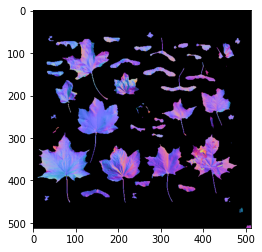

In [6]:
if __name__ == "__main__":
    normal_map(LIGHT_IMAGE_PATHS, OUTPUT_PATH, MASK_PATH)
